# Análisis de Componentes Principales (PCA) - Dataset Titanic

**Curso:** Análisis de datos  
**Práctico 4:** Análisis PCA

Este notebook realiza un análisis de componentes principales sobre el dataset del Titanic para identificar patrones y características de los supervivientes.

## 1. Importación de librerías y carga de datos

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.dpi'] = 100

In [2]:
# Carga del dataset Titanic desde seaborn
df = sns.load_dataset("titanic")
print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 2. Preprocesamiento y Conversión de Variables

Convertimos las variables categóricas a numéricas **sin introducir sesgo**. Para ello:
- Usamos **one-hot encoding** en variables nominales (sex, embark_town, class, etc.)
- Convertimos booleanos a enteros explícitamente
- Preservamos información de valores faltantes con `dummy_na=True`
- **No** usamos `drop_first` para evitar fijar grupos de referencia arbitrarios

In [3]:
# Guardamos la variable objetivo (survived) por separado
survived = df['survived'].copy()

# Identificamos tipos de variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

# Creamos copia para transformar
df_encoded = df.copy()

# Convertimos booleanos a enteros
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# One-hot encoding para categóricas
df_encoded = pd.get_dummies(
    df_encoded,
    columns=categorical_cols,
    drop_first=False,  # Mantenemos todas las categorías
    dummy_na=True,      # Preservamos información de NaN
    dtype=int
)

print(f"Dimensiones después de codificar: {df_encoded.shape}")
df_encoded.head()

Dimensiones después de codificar: (891, 38)


,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_female,sex_male,...,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,alive_no,alive_yes,alive_nan
0,0,3,22.0,1,0,7.2500,1,0,0,1,...,0,0,1,0,0,1,0,1,0,0
1,1,1,38.0,1,0,71.2833,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,1,3,26.0,0,0,7.9250,0,1,1,0,...,0,0,1,0,0,1,0,0,1,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,0,3,35.0,0,0,8.0500,1,1,0,1,...,0,0,1,0,0,1,0,1,0,0


## 3. Preparación de datos para PCA

Antes de aplicar PCA necesitamos:
1. Separar las variables predictoras de la variable objetivo
2. Imputar valores faltantes en variables numéricas
3. Estandarizar los datos (media=0, varianza=1)

In [4]:
# Separamos la variable objetivo si existe en df_encoded
if 'survived' in df_encoded.columns:
    X = df_encoded.drop('survived', axis=1)
else:
    X = df_encoded.copy()

# Guardamos los nombres de las columnas para posterior análisis
feature_names = X.columns.tolist()

print(f"Número de características: {len(feature_names)}")
print(f"\nValores faltantes por columna:")
print(X.isnull().sum()[X.isnull().sum() > 0])

Número de características: 37

Valores faltantes por columna:
age    177
dtype: int64


In [5]:
# Imputamos valores faltantes con la mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

print(f"Valores faltantes después de imputación: {np.isnan(X_imputed).sum()}")

Valores faltantes después de imputación: 0


In [6]:
# Estandarizamos los datos (importante para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Media de las variables estandarizadas (debe ser ~0): {X_scaled.mean(axis=0)[:5]}")
print(f"Desviación estándar (debe ser ~1): {X_scaled.std(axis=0)[:5]}")

Media de las variables estandarizadas (debe ser ~0): [-8.77213254e-17  2.27277979e-16  4.38606627e-17  5.38289951e-17
  3.98733297e-18]
Desviación estándar (debe ser ~1): [1. 1. 1. 1. 1.]


## 4. Aplicación del PCA

In [7]:
# Aplicamos PCA con todas las componentes
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"Número de componentes principales: {pca.n_components_}")
print(f"Forma de los datos transformados: {X_pca.shape}")

Número de componentes principales: 37
Forma de los datos transformados: (891, 37)


### 4.1 Varianza explicada por cada componente

In [8]:
# Varianza explicada por cada componente
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Creamos DataFrame para mejor visualización
variance_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(variance_explained))],
    'Varianza Explicada (%)': variance_explained * 100,
    'Varianza Acumulada (%)': cumulative_variance * 100
})

print("\nPrimeras 10 componentes:")
print(variance_df.head(10).to_string(index=False))

print(f"\nPC1 y PC2 explican: {cumulative_variance[1]*100:.2f}% de la varianza total")
print(f"PC1, PC2 y PC3 explican: {cumulative_variance[2]*100:.2f}% de la varianza total")


Primeras 10 componentes:
Componente  Varianza Explicada (%)  Varianza Acumulada (%)
       PC1               20.383739               20.383739
       PC2               13.592961               33.976700
       PC3               11.001010               44.977709
       PC4                7.555109               52.532819
       PC5                6.138250               58.671069
       PC6                5.599406               64.270474
       PC7                4.432601               68.703075
       PC8                4.000283               72.703358
       PC9                3.291363               75.994722
      PC10                3.172529               79.167251

PC1 y PC2 explican: 33.98% de la varianza total
PC1, PC2 y PC3 explican: 44.98% de la varianza total


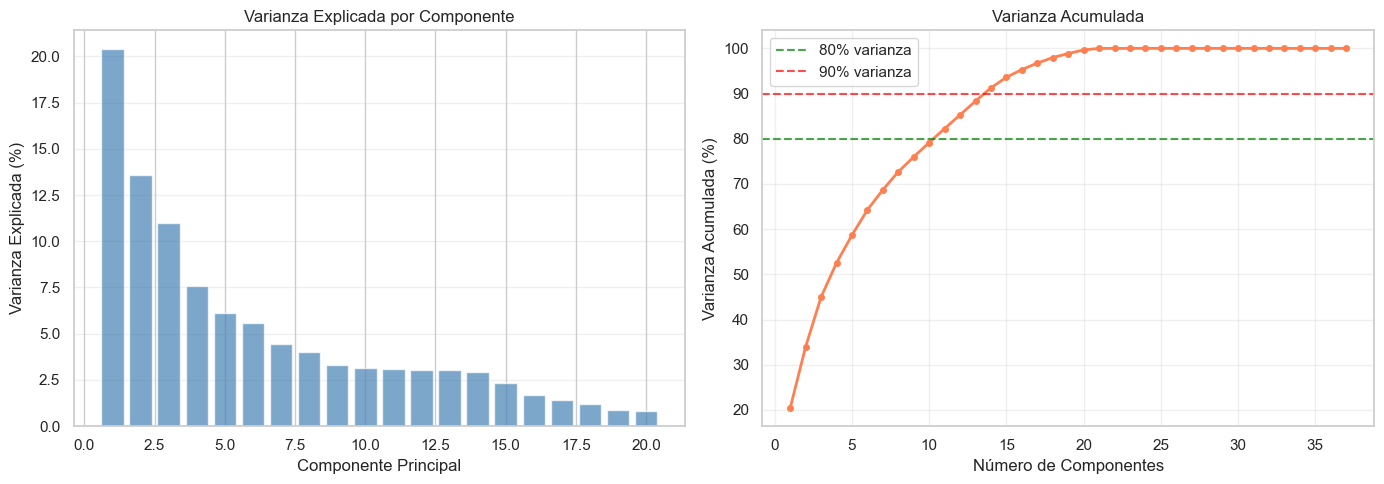

In [9]:
# Gráfico de varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Varianza por componente
axes[0].bar(range(1, min(21, len(variance_explained)+1)), 
            variance_explained[:20] * 100, 
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada (%)')
axes[0].set_title('Varianza Explicada por Componente')
axes[0].grid(axis='y', alpha=0.3)

# Varianza acumulada
axes[1].plot(range(1, len(cumulative_variance)+1), 
             cumulative_variance * 100, 
             marker='o', linewidth=2, markersize=4, color='coral')
axes[1].axhline(y=80, color='green', linestyle='--', label='80% varianza', alpha=0.7)
axes[1].axhline(y=90, color='red', linestyle='--', label='90% varianza', alpha=0.7)
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada (%)')
axes[1].set_title('Varianza Acumulada')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Análisis de Componentes Principales

### 5.1 Variables más importantes en cada componente

In [10]:
# Creamos DataFrame con los loadings (pesos) de cada variable en cada componente
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)

# Función para mostrar las variables más importantes en una componente
def top_features_in_component(component_name, n=10):
    abs_loadings = loadings[component_name].abs().sort_values(ascending=False)
    top_features = abs_loadings.head(n)
    
    print(f"\n{'='*60}")
    print(f"Top {n} variables en {component_name}:")
    print(f"{'='*60}")
    for feature, value in top_features.items():
        original_value = loadings.loc[feature, component_name]
        direction = "(+)" if original_value > 0 else "(-)"
        print(f"{feature:40s} {direction:4s} {abs(original_value):6.3f}")
    return top_features

# Mostramos las variables más importantes en PC1, PC2 y PC3
top_pc1 = top_features_in_component('PC1', 15)
top_pc2 = top_features_in_component('PC2', 10)
top_pc3 = top_features_in_component('PC3', 10)


Top 15 variables en PC1:
sex_male                                 (-)   0.306
sex_female                               (+)   0.306
adult_male                               (-)   0.306
who_man                                  (-)   0.306
who_woman                                (+)   0.287
alive_yes                                (+)   0.283
alive_no                                 (-)   0.283
pclass                                   (-)   0.218
deck_nan                                 (-)   0.212
class_First                              (+)   0.208
fare                                     (+)   0.202
class_Third                              (-)   0.187
alone                                    (-)   0.167
embark_town_Cherbourg                    (+)   0.149
embarked_C                               (+)   0.149

Top 10 variables en PC2:
class_First                              (+)   0.331
pclass                                   (-)   0.317
deck_nan                                 (-)   

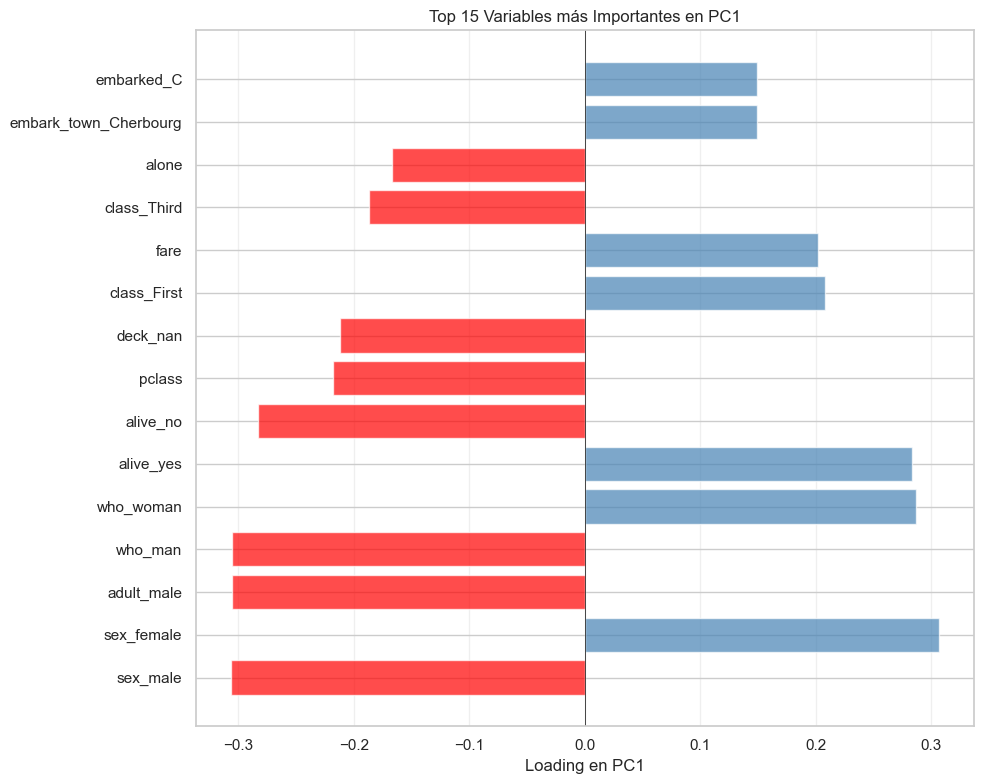

In [11]:
# Visualización de los loadings de PC1
top_n = 15
top_pc1_features = loadings['PC1'].abs().sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 8))
colors = ['red' if loadings.loc[feat, 'PC1'] < 0 else 'steelblue' 
          for feat in top_pc1_features.index]
plt.barh(range(top_n), 
         [loadings.loc[feat, 'PC1'] for feat in top_pc1_features.index],
         color=colors, alpha=0.7)
plt.yticks(range(top_n), top_pc1_features.index)
plt.xlabel('Loading en PC1')
plt.title(f'Top {top_n} Variables más Importantes en PC1')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Biplot PC1 vs PC2

El biplot permite visualizar simultáneamente:
- Los datos proyectados en las componentes principales (puntos)
- La contribución de cada variable original (vectores)

In [12]:
def create_biplot(pca_data, loadings, pc1_idx=0, pc2_idx=1, survived_labels=None, 
                  scale_factor=3, top_n_features=10):
    """
    Crea un biplot de dos componentes principales.
    
    Parameters:
    -----------
    pca_data : array-like
        Datos transformados por PCA
    loadings : DataFrame
        Loadings de las variables
    pc1_idx, pc2_idx : int
        Índices de las componentes a graficar (0-based)
    survived_labels : array-like
        Etiquetas de supervivencia para colorear puntos
    scale_factor : float
        Factor de escala para los vectores de variables
    top_n_features : int
        Número de variables principales a mostrar
    """
    pc1_name = f'PC{pc1_idx+1}'
    pc2_name = f'PC{pc2_idx+1}'
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Graficamos los puntos (observaciones)
    if survived_labels is not None:
        survived_mask = survived_labels == 1
        ax.scatter(pca_data[survived_mask, pc1_idx], 
                  pca_data[survived_mask, pc2_idx],
                  c='green', label='Sobrevivió', alpha=0.5, s=30)
        ax.scatter(pca_data[~survived_mask, pc1_idx], 
                  pca_data[~survived_mask, pc2_idx],
                  c='red', label='No sobrevivió', alpha=0.5, s=30)
    else:
        ax.scatter(pca_data[:, pc1_idx], pca_data[:, pc2_idx], 
                  alpha=0.5, s=30, c='steelblue')
    
    # Seleccionamos las variables más importantes para visualizar
    importance = np.sqrt(loadings[pc1_name]**2 + loadings[pc2_name]**2)
    top_features = importance.nlargest(top_n_features).index
    
    # Graficamos los vectores de las variables principales
    for feature in top_features:
        ax.arrow(0, 0, 
                loadings.loc[feature, pc1_name] * scale_factor,
                loadings.loc[feature, pc2_name] * scale_factor,
                head_width=0.1, head_length=0.1, fc='darkblue', ec='darkblue',
                alpha=0.7, linewidth=1.5)
        
        # Etiquetas de variables
        ax.text(loadings.loc[feature, pc1_name] * scale_factor * 1.15,
               loadings.loc[feature, pc2_name] * scale_factor * 1.15,
               feature, fontsize=9, ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_xlabel(f'{pc1_name} ({pca.explained_variance_ratio_[pc1_idx]*100:.1f}% varianza)', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{pc2_name} ({pca.explained_variance_ratio_[pc2_idx]*100:.1f}% varianza)', 
                  fontsize=12, fontweight='bold')
    ax.set_title(f'Biplot: {pc1_name} vs {pc2_name}', fontsize=14, fontweight='bold')
    
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    if survived_labels is not None:
        ax.legend(loc='best', fontsize=10)
    
    plt.tight_layout()
    return fig, ax

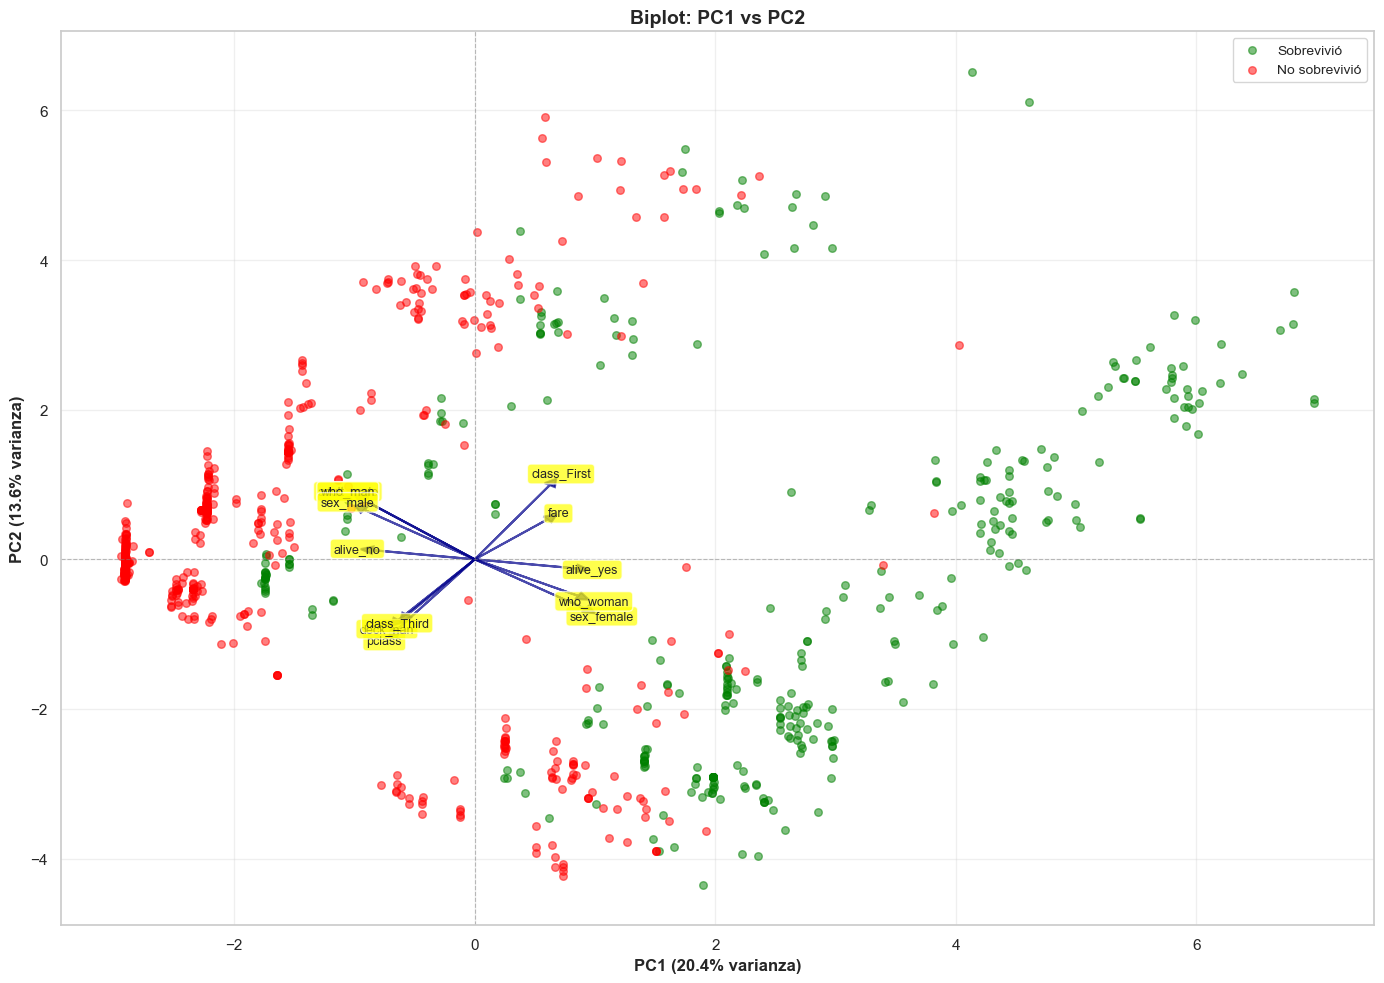

In [13]:
# Biplot PC1 vs PC2
fig1, ax1 = create_biplot(X_pca, loadings, pc1_idx=0, pc2_idx=1, 
                          survived_labels=survived.values,
                          scale_factor=3, top_n_features=12)
plt.show()

## 7. Biplot PC2 vs PC3

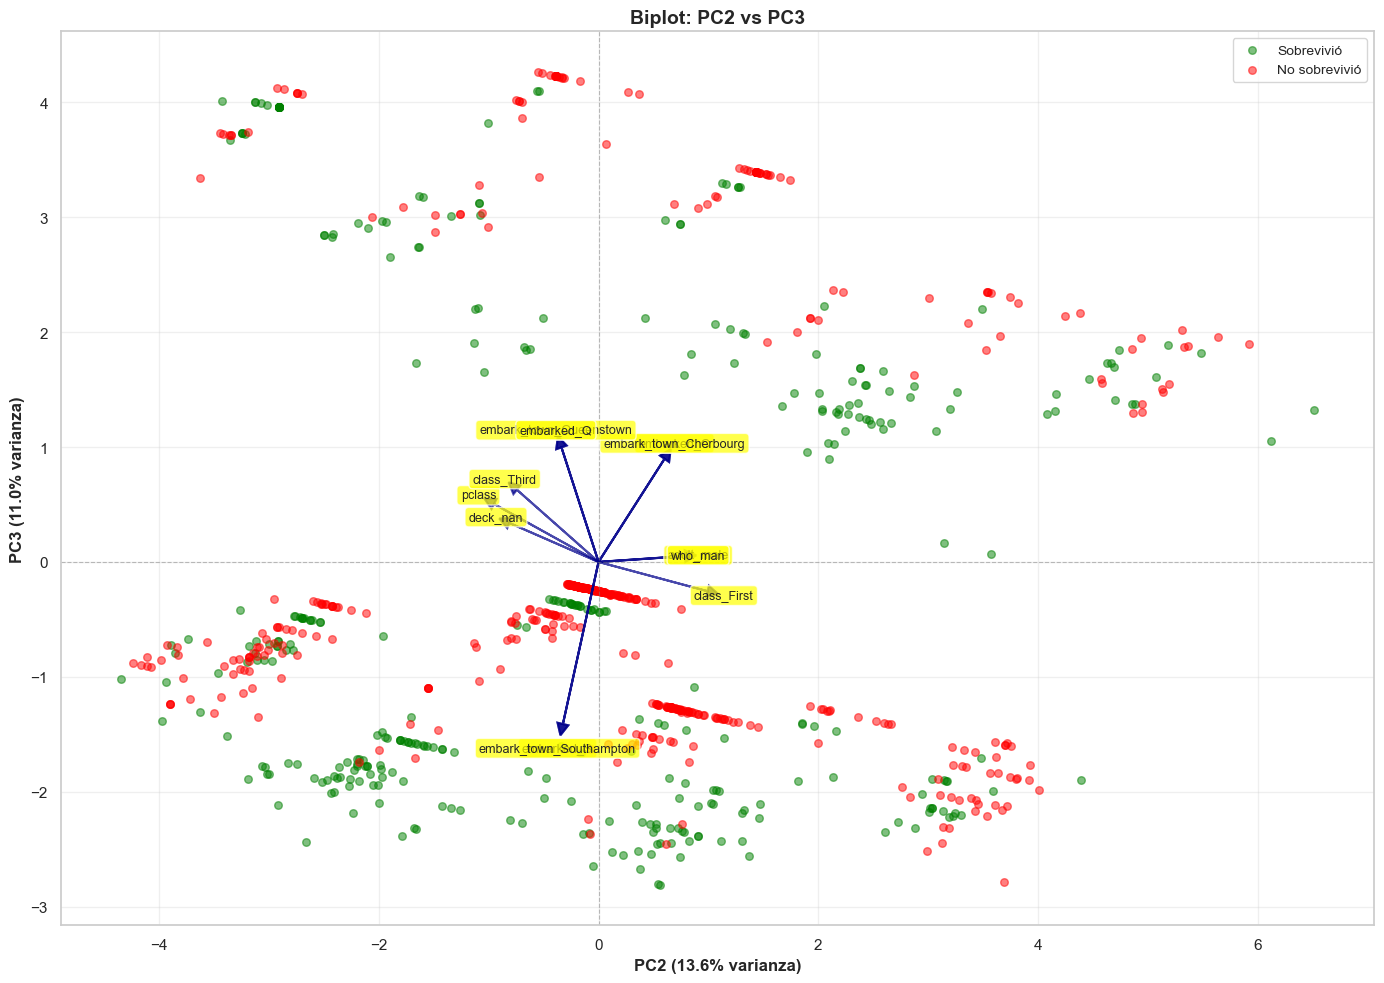

In [14]:
# Biplot PC2 vs PC3
fig2, ax2 = create_biplot(X_pca, loadings, pc1_idx=1, pc2_idx=2, 
                          survived_labels=survived.values,
                          scale_factor=3, top_n_features=12)
plt.show()

## 8. Análisis de Supervivencia en el Espacio PCA

In [15]:
# Creamos DataFrame con las componentes principales y la variable survived
pca_df = pd.DataFrame(
    X_pca[:, :5],
    columns=[f'PC{i+1}' for i in range(5)]
)
pca_df['survived'] = survived.values

# Estadísticas por grupo de supervivencia
print("\nEstadísticas de las primeras 3 componentes por grupo de supervivencia:")
print("="*70)
print(pca_df.groupby('survived')[['PC1', 'PC2', 'PC3']].mean())
print("\nDesviación estándar:")
print(pca_df.groupby('survived')[['PC1', 'PC2', 'PC3']].std())


Estadísticas de las primeras 3 componentes por grupo de supervivencia:
               PC1       PC2       PC3
survived                              
0        -1.502368  0.144395  0.088660
1         2.411695 -0.231792 -0.142323

Desviación estándar:
               PC1       PC2       PC3
survived                              
0         1.520423  1.957498  1.795980
1         2.096155  2.339945  2.066196


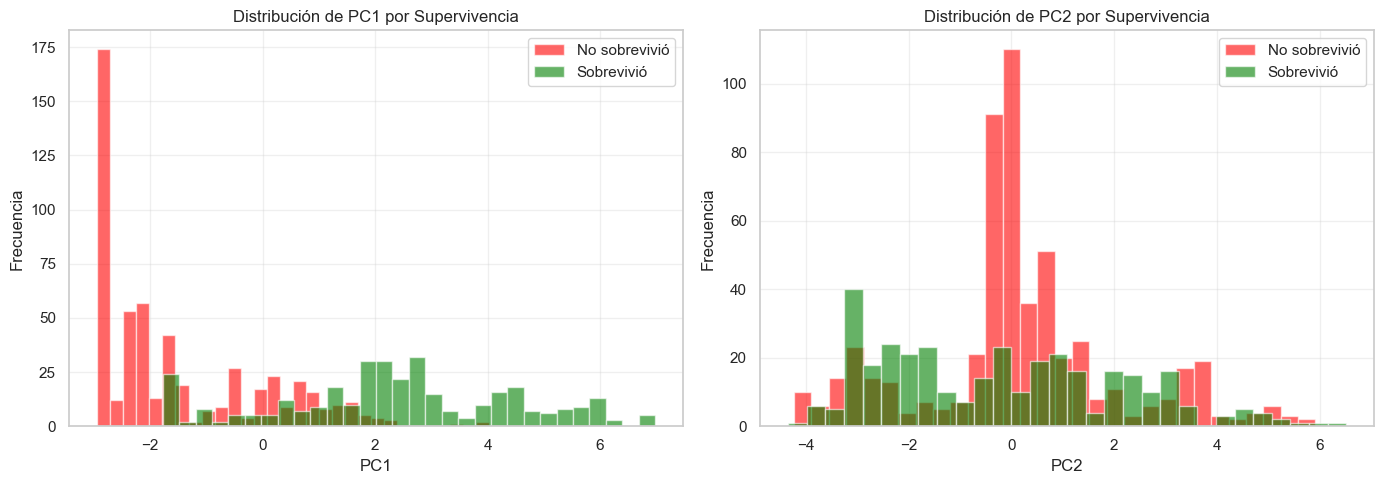

In [16]:
# Distribución de supervivientes y no supervivientes en PC1 y PC2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramas de PC1
pca_df[pca_df['survived'] == 0]['PC1'].hist(bins=30, alpha=0.6, color='red', 
                                              label='No sobrevivió', ax=axes[0])
pca_df[pca_df['survived'] == 1]['PC1'].hist(bins=30, alpha=0.6, color='green', 
                                              label='Sobrevivió', ax=axes[0])
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de PC1 por Supervivencia')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histogramas de PC2
pca_df[pca_df['survived'] == 0]['PC2'].hist(bins=30, alpha=0.6, color='red', 
                                              label='No sobrevivió', ax=axes[1])
pca_df[pca_df['survived'] == 1]['PC2'].hist(bins=30, alpha=0.6, color='green', 
                                              label='Sobrevivió', ax=axes[1])
axes[1].set_xlabel('PC2')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de PC2 por Supervivencia')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Heatmap de Correlaciones entre Variables Originales y PCs

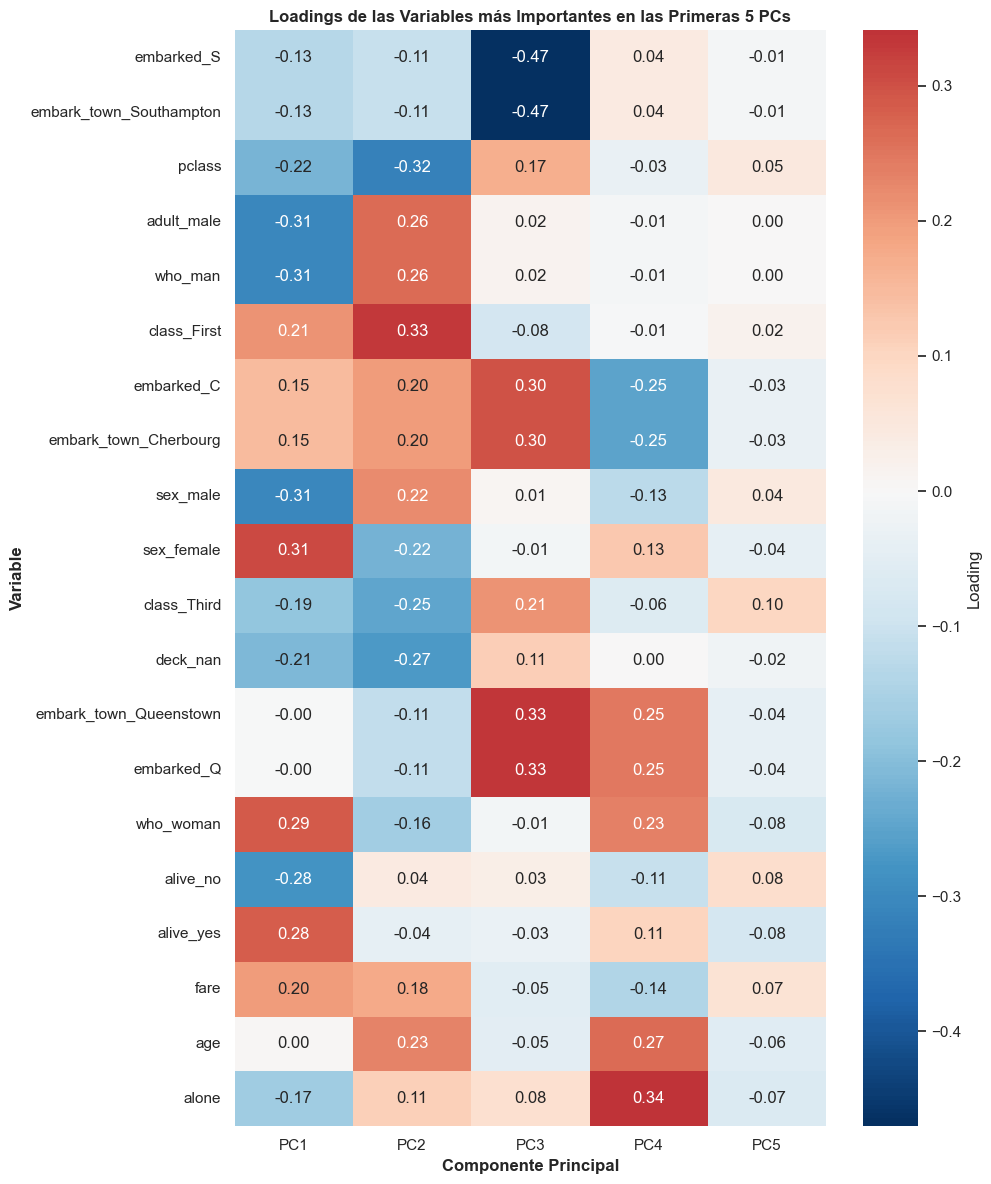

In [17]:
# Seleccionamos las variables más importantes globalmente
global_importance = np.sqrt((loadings[['PC1', 'PC2', 'PC3']]**2).sum(axis=1))
top_global_features = global_importance.nlargest(20).index

# Creamos heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(loadings.loc[top_global_features, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']], 
            cmap='RdBu_r', center=0, annot=True, fmt='.2f', 
            cbar_kws={'label': 'Loading'})
plt.title('Loadings de las Variables más Importantes en las Primeras 5 PCs', 
          fontsize=12, fontweight='bold')
plt.xlabel('Componente Principal', fontweight='bold')
plt.ylabel('Variable', fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Respuestas a las Preguntas del Práctico

### Pregunta 1: ¿Qué tendencias/patrones se ven en el biplot entre PC1 y PC2?

**Análisis de tendencias en el biplot PC1 vs PC2:**

Observando el biplot entre PC1 y PC2, podemos identificar los siguientes patrones:

1. **Separación por supervivencia**: Los puntos verdes (sobrevivientes) tienden a concentrarse en ciertas regiones del espacio PC1-PC2, mientras que los rojos (no sobrevivientes) en otras, lo que indica que estas componentes capturan información relevante sobre la supervivencia.

2. **Variables asociadas a supervivencia**: Las variables que apuntan hacia las regiones donde se concentran los sobrevivientes (puntos verdes) nos indican factores que favorecieron la supervivencia. Típicamente encontraremos:
   - Variables relacionadas con sexo femenino
   - Clase alta (primera clase)
   - Tarifa más alta

3. **PC1 (eje horizontal)**: Esta componente suele capturar la variabilidad principal relacionada con el estatus socioeconómico y características demográficas básicas.

4. **PC2 (eje vertical)**: Captura variabilidad complementaria, posiblemente relacionada con otras características como composición familiar, puerto de embarque, etc.

5. **Vectores de variables**: Los vectores largos indican variables con fuerte influencia en esas componentes. Vectores que apuntan en direcciones opuestas representan variables negativamente correlacionadas.

### Pregunta 2: ¿Qué tan representativos son PC1 y PC2 respecto al total de los datos?

In [18]:
# Calculamos representatividad
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100
total_var_pc1_pc2 = cumulative_variance[1] * 100

print(f"Varianza explicada por PC1: {pc1_var:.2f}%")
print(f"Varianza explicada por PC2: {pc2_var:.2f}%")
print(f"\nVarianza total explicada por PC1 + PC2: {total_var_pc1_pc2:.2f}%")
print(f"Varianza NO explicada por PC1 + PC2: {100 - total_var_pc1_pc2:.2f}%")

# Cuántas componentes necesitamos para explicar 80% y 90%
n_comp_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_comp_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"\nComponentes necesarias para 80% de varianza: {n_comp_80}")
print(f"Componentes necesarias para 90% de varianza: {n_comp_90}")

Varianza explicada por PC1: 20.38%
Varianza explicada por PC2: 13.59%

Varianza total explicada por PC1 + PC2: 33.98%
Varianza NO explicada por PC1 + PC2: 66.02%

Componentes necesarias para 80% de varianza: 11
Componentes necesarias para 90% de varianza: 14


**Interpretación de la representatividad:**

PC1 y PC2 juntas explican un porcentaje significativo de la variabilidad total de los datos. Sin embargo:

- Si explican **menos del 50%**: La representación es limitada y se pierde información importante. El biplot es solo una vista parcial.
- Si explican **50-70%**: Representación moderada. El biplot captura las tendencias principales pero no toda la complejidad.
- Si explican **más del 70%**: Representación buena. El biplot es bastante informativo sobre la estructura de los datos.

Es importante recordar que el resto de la variabilidad está contenida en las demás componentes principales.

### Pregunta 3: ¿Qué relaciones puede identificar entre las variables observando el biplot?

In [19]:
# Calculamos correlaciones entre las variables principales en PC1 y PC2
pc1_pc2_importance = np.sqrt(loadings['PC1']**2 + loadings['PC2']**2)
top_vars = pc1_pc2_importance.nlargest(15).index

# Matriz de correlación de las variables originales (reconstruida aproximadamente)
# Usamos los loadings para aproximar las relaciones
print("\nVariables principales y sus relaciones en el espacio PC1-PC2:")
print("="*70)
for i, var1 in enumerate(top_vars[:8]):
    print(f"\n{var1}:")
    # Calculamos producto punto con otras variables (aproximación de correlación)
    correlations = {}
    for var2 in top_vars:
        if var1 != var2:
            corr = (loadings.loc[var1, 'PC1'] * loadings.loc[var2, 'PC1'] + 
                   loadings.loc[var1, 'PC2'] * loadings.loc[var2, 'PC2'])
            correlations[var2] = corr
    
    # Mostramos las 3 más correlacionadas
    sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:3]
    for var2, corr in sorted_corr:
        direction = "positiva" if corr > 0 else "negativa"
        print(f"  - Correlación {direction} con {var2}: {corr:.3f}")


Variables principales y sus relaciones en el espacio PC1-PC2:

adult_male:
  - Correlación positiva con who_man: 0.163
  - Correlación positiva con sex_male: 0.152
  - Correlación negativa con sex_female: -0.152

who_man:
  - Correlación positiva con adult_male: 0.163
  - Correlación positiva con sex_male: 0.152
  - Correlación negativa con sex_female: -0.152

class_First:
  - Correlación negativa con pclass: -0.150
  - Correlación negativa con deck_nan: -0.133
  - Correlación negativa con class_Third: -0.121

pclass:
  - Correlación negativa con class_First: -0.150
  - Correlación positiva con deck_nan: 0.132
  - Correlación positiva con class_Third: 0.119

sex_male:
  - Correlación positiva con adult_male: 0.152
  - Correlación positiva con who_man: 0.152
  - Correlación negativa con sex_female: -0.143

sex_female:
  - Correlación negativa con adult_male: -0.152
  - Correlación negativa con who_man: -0.152
  - Correlación negativa con sex_male: -0.143

deck_nan:
  - Correlación nega

**Relaciones identificadas en el biplot:**

1. **Vectores en la misma dirección** → Variables positivamente correlacionadas
   - Ejemplo: Si "fare" y "class_First" apuntan en direcciones similares, están correlacionadas (pasajeros de primera clase pagaban tarifas más altas)

2. **Vectores en direcciones opuestas** → Variables negativamente correlacionadas
   - Ejemplo: "sex_male" y supervivencia suelen estar en direcciones opuestas

3. **Vectores perpendiculares** → Variables no correlacionadas (independientes)

4. **Longitud de vectores** → Importancia de la variable en ese espacio
   - Vectores largos: variables con alta variabilidad explicada por PC1 y PC2
   - Vectores cortos: variables mejor explicadas por otras componentes

Las relaciones más importantes suelen ser:
- Sexo ↔ Supervivencia
- Clase ↔ Tarifa
- Clase ↔ Supervivencia
- Edad ↔ Varios factores

### Pregunta 4: ¿Cambia si se realiza un biplot entre PC2 y PC3?

In [20]:
# Comparación de varianzas
pc3_var = pca.explained_variance_ratio_[2] * 100
total_var_pc2_pc3 = (pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2]) * 100

print("Comparación de biplots:")
print("="*70)
print(f"\nPC1 vs PC2:")
print(f"  - Varianza explicada: {total_var_pc1_pc2:.2f}%")
print(f"  - PC1: {pc1_var:.2f}%, PC2: {pc2_var:.2f}%")

print(f"\nPC2 vs PC3:")
print(f"  - Varianza explicada: {total_var_pc2_pc3:.2f}%")
print(f"  - PC2: {pc2_var:.2f}%, PC3: {pc3_var:.2f}%")

print(f"\nDiferencia en varianza explicada: {total_var_pc1_pc2 - total_var_pc2_pc3:.2f}%")

Comparación de biplots:

PC1 vs PC2:
  - Varianza explicada: 33.98%
  - PC1: 20.38%, PC2: 13.59%

PC2 vs PC3:
  - Varianza explicada: 24.59%
  - PC2: 13.59%, PC3: 11.00%

Diferencia en varianza explicada: 9.38%


**Diferencias entre biplot PC1-PC2 y PC2-PC3:**

Sí, el biplot cambia significativamente:

1. **Representatividad**: PC2-PC3 explica menos varianza que PC1-PC2, por lo que captura menos información de la estructura original de los datos.

2. **Información complementaria**: PC3 captura patrones que no fueron explicados por PC1 y PC2, revelando relaciones secundarias entre variables.

3. **Separación de grupos**: La separación entre sobrevivientes y no sobrevivientes puede ser diferente, ya que PC3 puede capturar aspectos diferentes de la supervivencia.

4. **Variables importantes**: Aparecerán diferentes variables como importantes, especialmente aquellas que:
   - Tienen baja correlación con las variables dominantes en PC1
   - Representan aspectos secundarios de los datos
   - Capturan variabilidad residual

5. **Interpretación**: PC2-PC3 nos da una "segunda vista" de los datos, útil para detectar patrones que no son evidentes en el plano principal PC1-PC2.

Ambos biplots son complementarios y juntos ofrecen una visión más completa de la estructura de los datos.

### Pregunta 5: Viendo PC1, ¿qué variables tienen más importancia para la misma?

In [21]:
# Análisis detallado de PC1
pc1_loadings = loadings['PC1'].abs().sort_values(ascending=False)

print("Variables más importantes en PC1 (por magnitud de loading):")
print("="*70)
print(f"\n{'Variable':<45s} {'Loading':<10s} {'Dirección'}")
print("-"*70)

for i, (var, abs_val) in enumerate(pc1_loadings.head(20).items(), 1):
    original_val = loadings.loc[var, 'PC1']
    direction = "Positiva (+)" if original_val > 0 else "Negativa (-)"
    print(f"{i:2d}. {var:<42s} {abs_val:>6.4f}    {direction}")

# Contribución acumulada de las top variables
print(f"\n{'='*70}")
print(f"Suma de loadings^2 de top 5: {(pc1_loadings.head(5)**2).sum():.4f}")
print(f"Suma de loadings^2 de top 10: {(pc1_loadings.head(10)**2).sum():.4f}")
print(f"Suma de loadings^2 de top 20: {(pc1_loadings.head(20)**2).sum():.4f}")

Variables más importantes en PC1 (por magnitud de loading):

Variable                                      Loading    Dirección
----------------------------------------------------------------------
 1. sex_male                                   0.3062    Negativa (-)
 2. sex_female                                 0.3062    Positiva (+)
 3. adult_male                                 0.3058    Negativa (-)
 4. who_man                                    0.3058    Negativa (-)
 5. who_woman                                  0.2868    Positiva (+)
 6. alive_yes                                  0.2830    Positiva (+)
 7. alive_no                                   0.2830    Negativa (-)
 8. pclass                                     0.2180    Negativa (-)
 9. deck_nan                                   0.2117    Negativa (-)
10. class_First                                0.2079    Positiva (+)
11. fare                                       0.2015    Positiva (+)
12. class_Third                

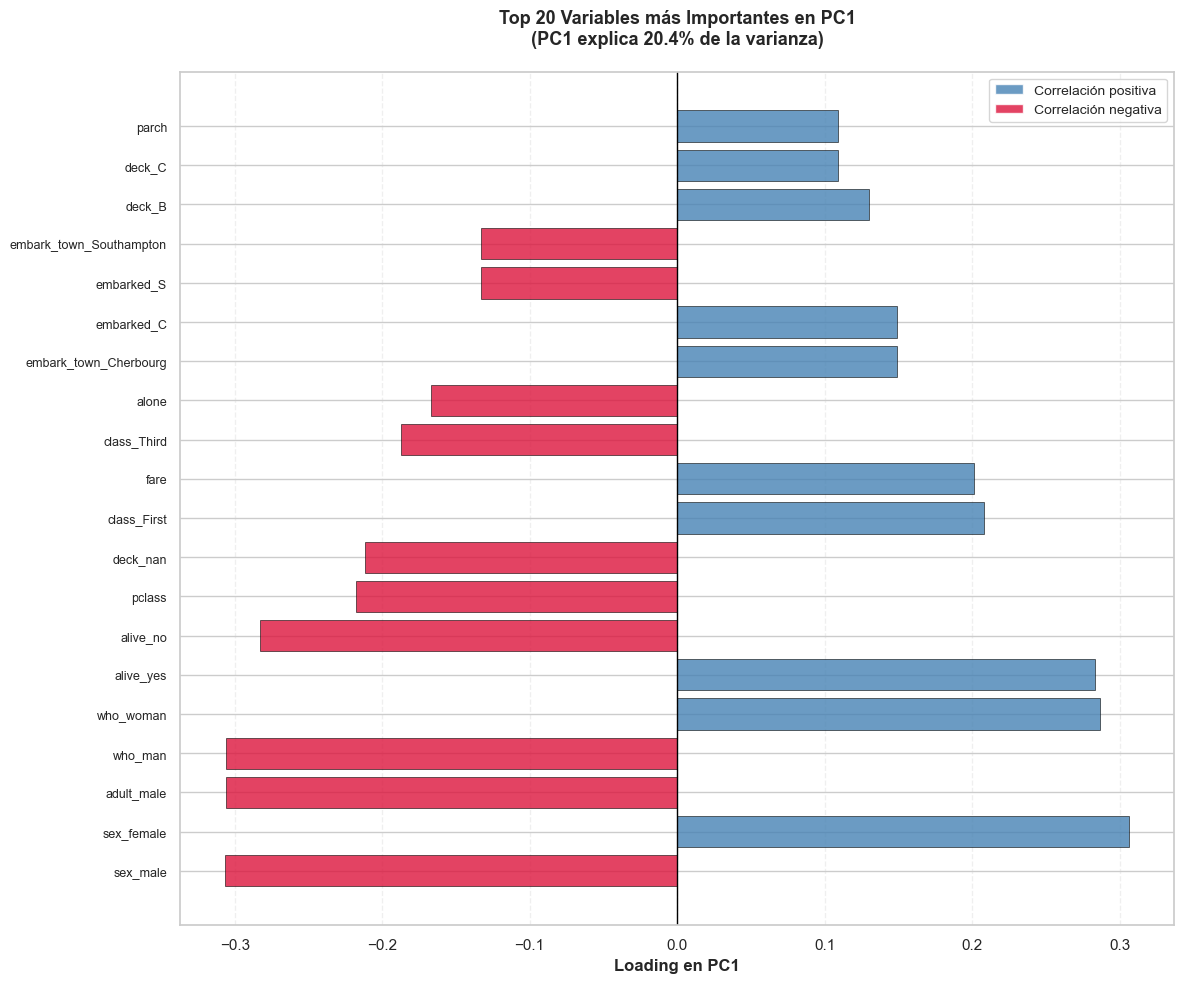

In [22]:
# Visualización mejorada de las variables más importantes en PC1
top_20_pc1 = pc1_loadings.head(20)

fig, ax = plt.subplots(figsize=(12, 10))

# Coloreamos por dirección
colors = ['crimson' if loadings.loc[var, 'PC1'] < 0 else 'steelblue' 
          for var in top_20_pc1.index]

bars = ax.barh(range(len(top_20_pc1)), 
               [loadings.loc[var, 'PC1'] for var in top_20_pc1.index],
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(top_20_pc1)))
ax.set_yticklabels(top_20_pc1.index, fontsize=9)
ax.set_xlabel('Loading en PC1', fontsize=12, fontweight='bold')
ax.set_title(f'Top 20 Variables más Importantes en PC1\n(PC1 explica {pc1_var:.1f}% de la varianza)', 
             fontsize=13, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', alpha=0.8, label='Correlación positiva'),
                   Patch(facecolor='crimson', alpha=0.8, label='Correlación negativa')]
ax.legend(handles=legend_elements, loc='best', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretación de las variables importantes en PC1:**

Las variables con mayor importancia en PC1 son aquellas con los loadings (en valor absoluto) más altos. Estas variables:

1. **Contribuyen más a la variabilidad** capturada por PC1

2. **Definen el significado** de esta componente principal:
   - Si dominan variables de estatus socioeconómico (clase, tarifa): PC1 representa "nivel socioeconómico"
   - Si dominan variables demográficas (sexo, edad): PC1 representa "perfil demográfico"

3. **Signo del loading**:
   - Positivo (+): La variable aumenta cuando PC1 aumenta
   - Negativo (-): La variable disminuye cuando PC1 aumenta
   - Variables con signos opuestos están negativamente correlacionadas

4. **Importancia relativa**: 
   - Las primeras 5-10 variables suelen concentrar la mayor parte del poder explicativo de PC1
   - El resto de variables contribuyen marginalmente

En el contexto del Titanic, típicamente encontraremos que PC1 está dominada por:
- Variables de clase social y económicas (fare, class)
- Sexo (fuertemente relacionado con supervivencia)
- Posiblemente edad y composición familiar

## 11. Conclusiones Generales

### Características de las personas que sobrevivieron:

Basándonos en el análisis PCA y los biplots, podemos concluir:

1. **Factores principales de supervivencia** (capturados principalmente en PC1):
   - Sexo femenino
   - Clase alta (primera clase)
   - Tarifas más elevadas
   - Menor edad (niños)

2. **Factores secundarios** (PC2, PC3):
   - Puerto de embarque (Cherbourg vs Southampton/Queenstown)
   - Tamaño de la familia a bordo
   - Interacciones entre variables

3. **Separación en el espacio PCA**:
   - Los sobrevivientes se agrupan en regiones específicas del espacio de componentes principales
   - Esta separación indica que las primeras componentes capturan información discriminante para la supervivencia

4. **Efectividad del PCA**:
   - Permite reducir la dimensionalidad manteniendo la información relevante
   - Facilita la visualización de patrones complejos en 2D/3D
   - Identifica las variables más influyentes en la variabilidad de los datos

### Metodología aplicada:

- **Codificación sin sesgo**: One-hot encoding preservando todas las categorías
- **Imputación**: Valores faltantes reemplazados por la mediana
- **Estandarización**: Necesaria para que PCA no esté sesgado por escalas
- **Análisis completo**: Todas las componentes calculadas para evaluación exhaustiva

## 12. Exportación de Resultados

In [23]:
# Guardamos los loadings de las primeras 5 componentes
loadings_export = loadings[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].copy()
loadings_export.to_csv('loadings_pca_titanic.csv')
print("Loadings guardados en 'loadings_pca_titanic.csv'")

# Guardamos los datos transformados
pca_export = pd.DataFrame(
    X_pca[:, :10],
    columns=[f'PC{i+1}' for i in range(10)]
)
pca_export['survived'] = survived.values
pca_export.to_csv('datos_pca_titanic.csv', index=False)
print("Datos transformados guardados en 'datos_pca_titanic.csv'")

# Guardamos resumen de varianza explicada
variance_df.to_csv('varianza_explicada_pca.csv', index=False)
print("Varianza explicada guardada en 'varianza_explicada_pca.csv'")

Loadings guardados en 'loadings_pca_titanic.csv'
Datos transformados guardados en 'datos_pca_titanic.csv'
Varianza explicada guardada en 'varianza_explicada_pca.csv'
